In [1]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from axessettings import AxesSetting, linear_sim

In [2]:
A0 = 10**(106/20)
wp = 2*np.pi*5
A = lambda s: A0/(1+s/wp)

In [39]:
def plot_bode(filename: str, fig = None, axes = None, name=None, argshift=None, legend=False, xlim=None, cutoff_db=-60):
    is_new = False
    if fig is None:
        is_new = True
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    df = pd.read_csv(filename, names=["f", "mag", "phase"], skiprows=1)
    if cutoff_db:
        df = df[df["mag"] > 10**(cutoff_db/20)]
    axes[0].plot(df["f"], 20*np.log10(df["mag"]), label=name if name else filename)
    axes[1].plot(df["f"], argshift(df["phase"]) if argshift else df["phase"], label=name if name else filename)
    if is_new:
        axstg1 = AxesSetting(title="Magnitude", xlabel="f [Hz]", ylabel="Gain [dB]", xscale="log", legend=legend, grid="both", xlim=xlim)
        axstg1.apply_axes(axes[0])
        axstg2 = AxesSetting(title="Phase", xlabel="f [Hz]", ylabel="Phase [$^\circ$]", xscale="log", legend=legend, grid="both", xlim=xlim)
        axstg2.apply_axes(axes[1])
        fig.tight_layout()
        fig.suptitle(name if name else filename)
    return fig, axes

def plot_bode_spice(filename: str, axes = None, name=None, argshift=None):
    df = pd.read_csv(filename, names=["f", "re", "im"], skiprows=1, sep=r"\t|,", engine="python")
    df["h"] = df["re"] + 1j*df["im"]
    df["mag"] = np.abs(df["h"])
    df["phase"] = np.angle(df["h"], deg=True)
    axes[0].plot(df["f"], 20*np.log10(df["mag"]), label=name if name else filename)
    axes[1].plot(df["f"], argshift(df["phase"]) if argshift else df["phase"], label=name if name else filename)

def plot_osc(filename: str, axes):
    df = pd.read_csv(filename, names=["t1", "v1", "t2", "v2"], skiprows=1, usecols=[0, 1, 3, 4])
    axes.plot(df["t1"], df["v1"], c="blue", label="CH1")
    axes.plot(df["t2"], df["v2"], c="orange", label="CH2")

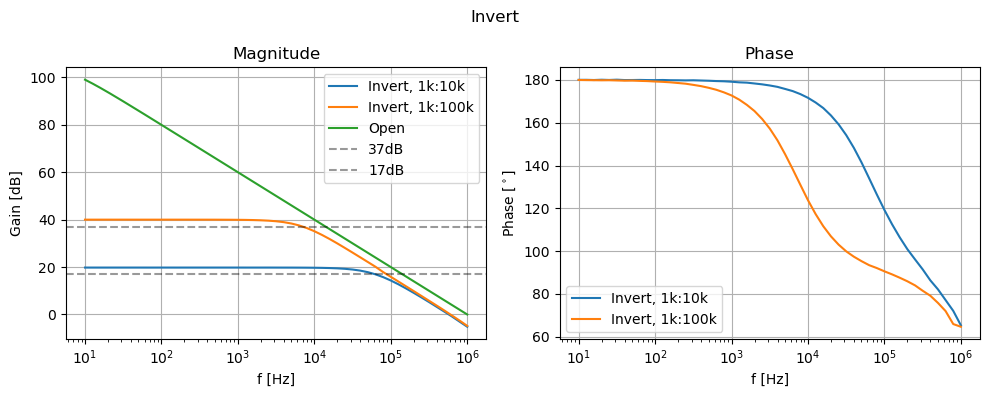

In [50]:
axstgs = [
    AxesSetting(title="Magnitude", xlabel="f [Hz]", ylabel="Gain [dB]", xscale="log", grid="both"),
    AxesSetting(title="Phase", xlabel="f [Hz]", ylabel="Phase [$^\circ$]", xscale="log", grid="both")
]
axstgs_osc = AxesSetting(title="Oscilloscope", xlabel="t [s]", ylabel="V [V]", grid="both")
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
plot_bode("1_bode_invert_1k_10k.csv", fig, axes, name="Invert, 1k:10k", argshift=lambda x: x+360)
plot_bode("1_bode_invert_1k_100k.csv", fig, axes, name="Invert, 1k:100k")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(A(2j*np.pi*f))), label="Open", xlim=(1e1, 1e6))
axes[0].axhline(40-3, color="black", alpha=0.4, linestyle="--", label="37dB")
axes[0].axhline(20-3, color="black", alpha=0.4, linestyle="--", label="17dB")
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Invert")
fig.tight_layout()

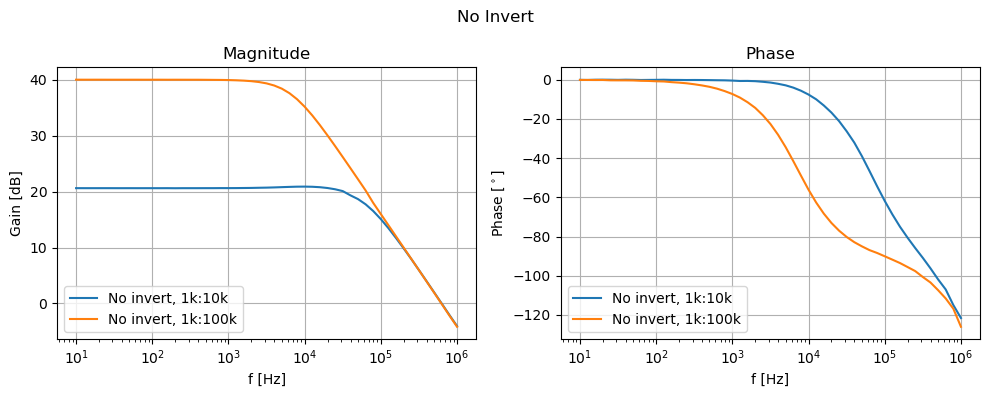

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("1_bode_noinvert_1k_10k.csv", fig, axes, name="No invert, 1k:10k")
plot_bode("1_bode_noinvert_1k_100k.csv", fig, axes, name="No invert, 1k:100k")
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("No Invert")
fig.tight_layout()

/tmp/ipykernel_16219/1439278160.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e6))


Text(0.5, 0, 't [$\\mu$s]')

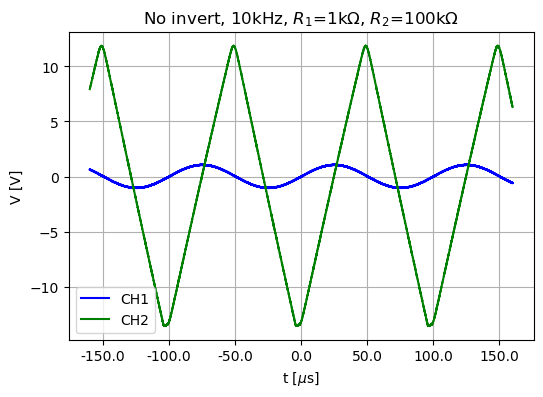

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("1_osc_noinvert_2Vpp_10kHz_1k_100k.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("No invert, 10kHz, $R_1$=1k$\Omega$, $R_2$=100k$\Omega$")
axes.set_xticklabels(np.round(axes.get_xticks()*1e6))
axes.set_xlabel("t [$\mu$s]")

In [ ]:
def A_derv(s, Cf, Rf, Cr, Rr):
    return -s*Cr*Rf/(s*Cr*Rr + 1)/(s*Cf*Rf + 1)

Cf = 214e-12
Cr = 218.6e-9
Rr = 9.981e3
Rf = 99.09e3

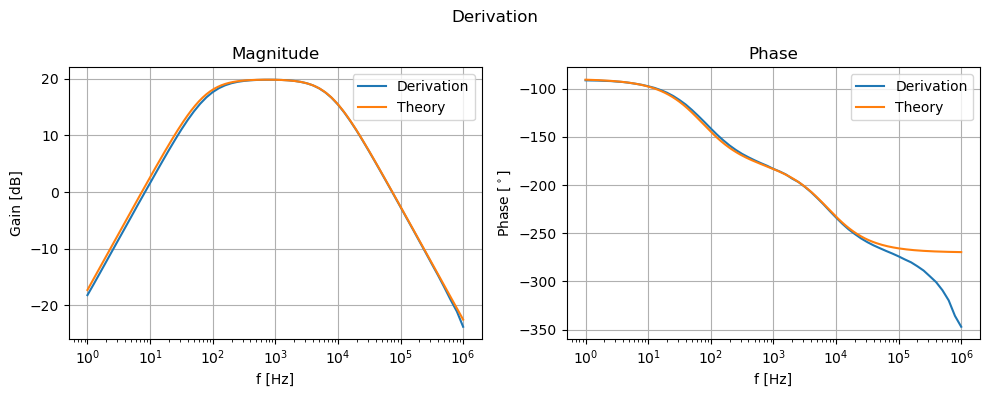

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("2_bode_derv.csv", fig, axes, name="Derivation")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(A_derv(2j*np.pi*f, Cf, Rf, Cr, Rr))), label="Theory", xlim=(1e0, 1e6))
axstgs[1].plot_func(axes[1], lambda f: (np.angle(A_derv(2j*np.pi*f, Cf, Rf, Cr, Rr), deg=True)+360)%360-360, label="Theory", xlim=(1e0, 1e6))
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Derivation")
fig.tight_layout()

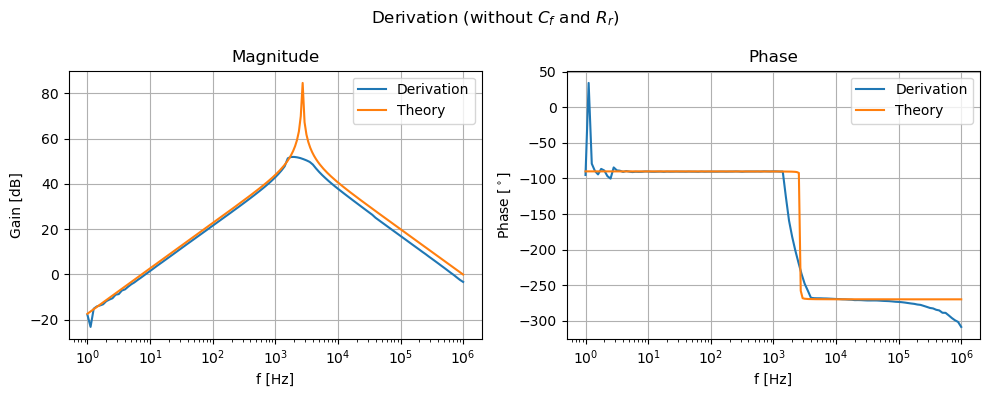

In [ ]:
beta = lambda s: 1/(1+s*Cr*Rf)
gain_dervwoutf = lambda s: -s*Cr*Rf*A(s)*beta(s)/(1+A(s)*beta(s))
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("2_bode_derv_woutf_wider.csv", fig, axes, name="Derivation")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(gain_dervwoutf(2j*np.pi*f))), label="Theory", xlim=(1e0, 1e6))
axstgs[1].plot_func(axes[1], lambda f: (np.angle(gain_dervwoutf(2j*np.pi*f), deg=True)+360)%360-360, label="Theory", xlim=(1e0, 1e6))
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Derivation (without $C_f$ and $R_r$)")
fig.tight_layout()

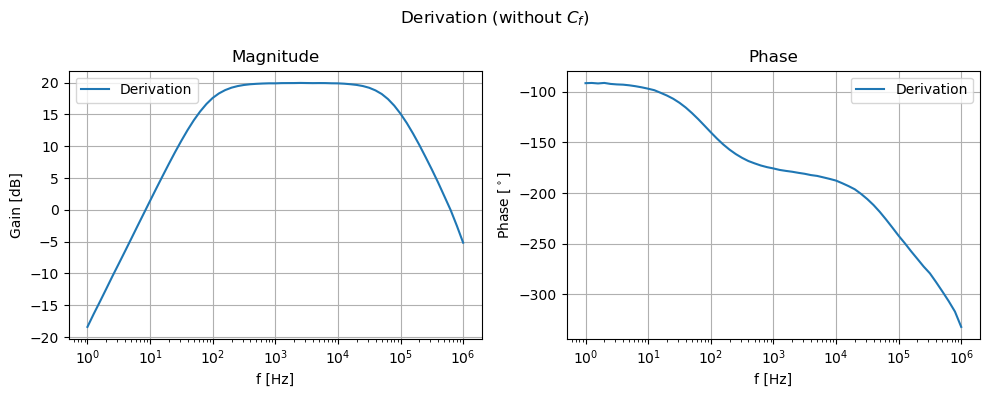

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("2_bode_derv_woutcf.csv", fig, axes, name="Derivation")
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Derivation (without $C_f$)")
fig.tight_layout()

In [ ]:
C1 = 24.33e-9
C2 = 21.88e-9


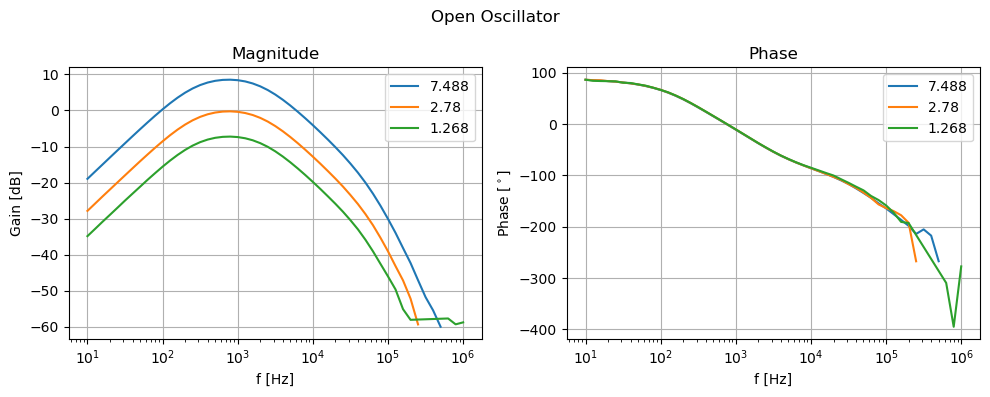

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("3_bode_7.488.csv", fig, axes, name="7.488")
plot_bode("3_bode_2.78.csv", fig, axes, name="2.78")
plot_bode("3_bode_1.268.csv", fig, axes, name="1.268")
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Open Oscillator")
fig.tight_layout()

In [59]:
axstgs_filters = [
    AxesSetting(title="Magnitude", xlabel="f [Hz]", ylabel="Gain [dB]", xscale="log", grid="both", ylim=(-60, 5), xlim=(1e0, 1e6)),
    AxesSetting(title="Phase", xlabel="f [Hz]", ylabel="Phase [$^\circ$]", xscale="log", grid="both", xlim=(1e0, 1e6))
]

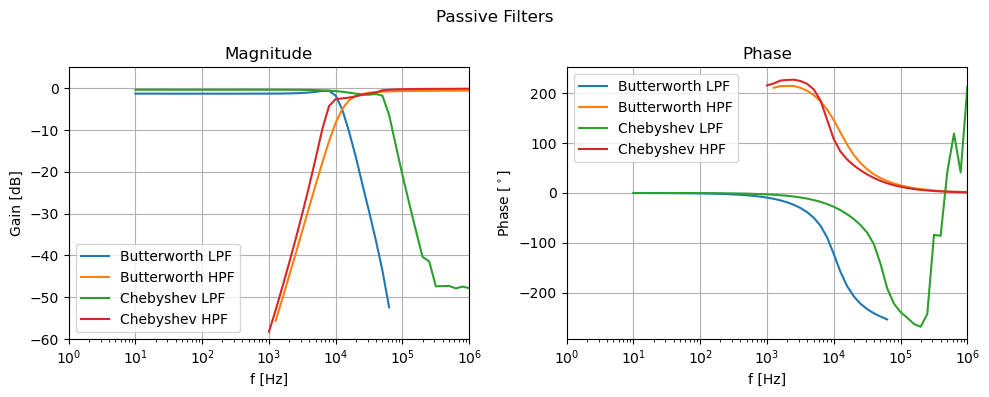

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("4_bode_bw3lpf.csv", fig, axes, name="Butterworth LPF")
plot_bode("4_bode_bw3hpf.csv", fig, axes, name="Butterworth HPF")
# plot_bode("4_bode_cheblpf.csv", fig, axes, name="Chebyshev LPF")
plot_bode("4_bode_cheblpf_re.csv", fig, axes, name="Chebyshev LPF")
plot_bode("4_bode_chebhpf.csv", fig, axes, name="Chebyshev HPF")
axstgs_filters[0].apply_axes(axes[0])
axstgs_filters[1].apply_axes(axes[1])
fig.suptitle("Passive Filters")
fig.tight_layout()

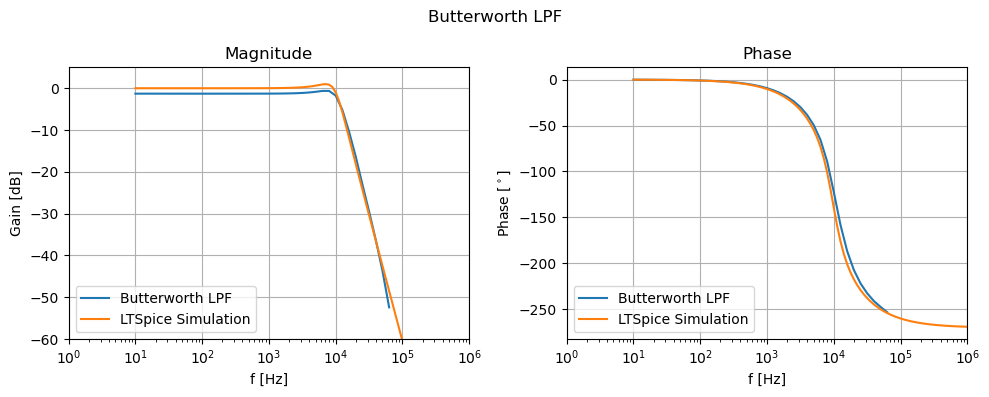

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
plot_bode("4_bode_bw3lpf.csv", fig, axes, name="Butterworth LPF")
plot_bode_spice("But_lpf.txt", axes, name="LTSpice Simulation", argshift=lambda x: (x+360)%360.0-360)
# plot_bode_spice("chevi_LPF.txt", axes, name="LTSpice Simulation", argshift=lambda x: (x+360)%360.0-360)
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
axstgs_filters[0].apply_axes(axes[0])
axstgs_filters[1].apply_axes(axes[1])
fig.suptitle("Butterworth LPF")
fig.tight_layout()

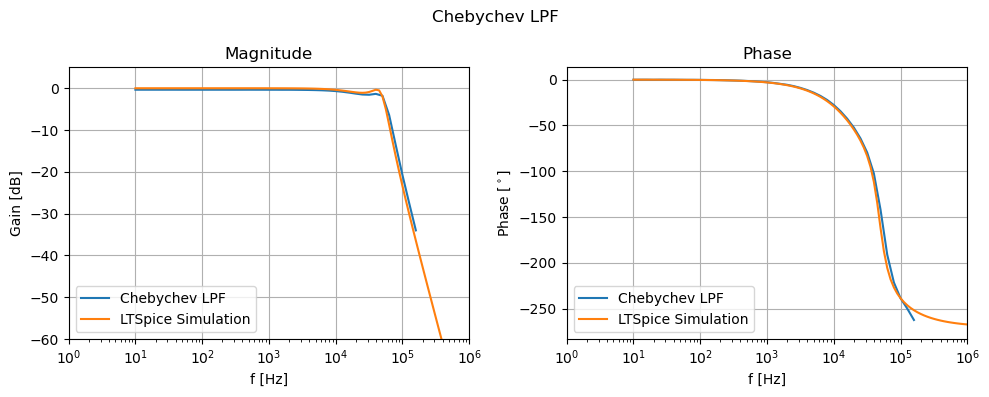

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("4_bode_cheblpf_re.csv", fig, axes, name="Chebychev LPF", cutoff_db=-40)
plot_bode_spice("chevi_LPF.txt", axes, name="LTSpice Simulation", argshift=lambda x: (x+360)%360.0-360)
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
axstgs_filters[0].apply_axes(axes[0])
axstgs_filters[1].apply_axes(axes[1])
fig.suptitle("Chebychev LPF")
fig.tight_layout()

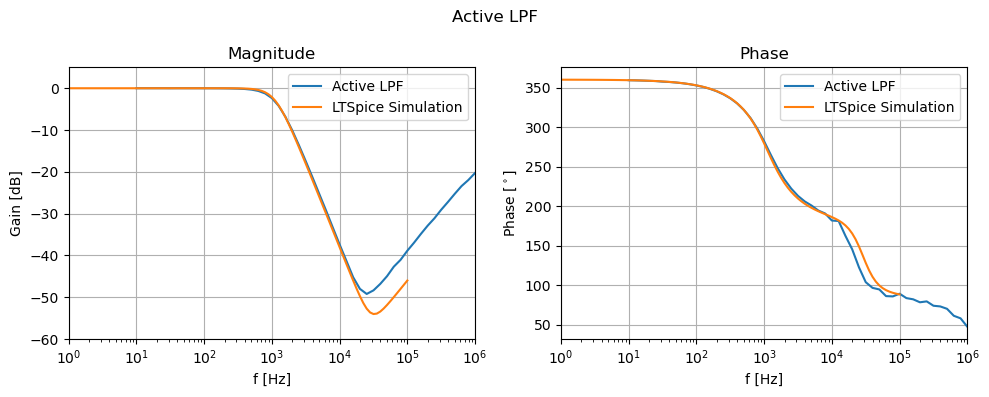

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("5_bode_activelpf.csv", fig, axes, name="Active LPF", cutoff_db=-60, argshift=lambda x: (x+360)%360.0)
plot_bode_spice("active_lpf.txt", axes, name="LTSpice Simulation", argshift=lambda x: (x+360)%360.0)
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
axstgs_filters[0].apply_axes(axes[0])
axstgs_filters[1].apply_axes(axes[1])
fig.suptitle("Active LPF")
fig.tight_layout()

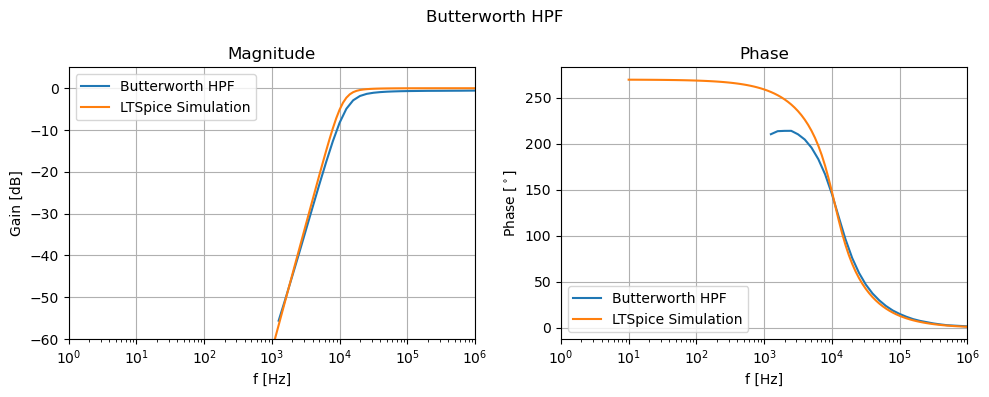

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("4_bode_bw3hpf.csv", fig, axes, name="Butterworth HPF", cutoff_db=-60, argshift=lambda x: (x+360)%360.0)
plot_bode_spice("But_HPF.txt", axes, name="LTSpice Simulation", argshift=lambda x: (x+360)%360.0)
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
axstgs_filters[0].apply_axes(axes[0])
axstgs_filters[1].apply_axes(axes[1])
fig.suptitle("Butterworth HPF")
fig.tight_layout()

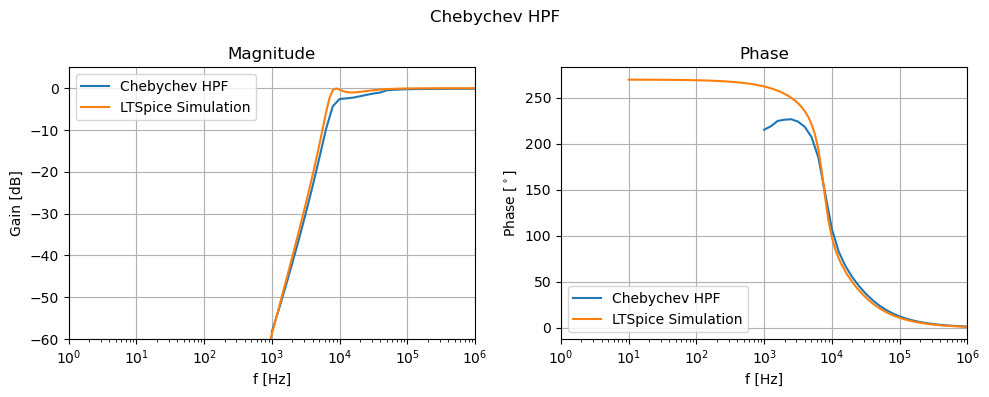

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("4_bode_chebhpf.csv", fig, axes, name="Chebychev HPF", cutoff_db=-60, argshift=lambda x: (x+360)%360.0)
plot_bode_spice("chevi_HPF.txt", axes, name="LTSpice Simulation", argshift=lambda x: (x+360)%360.0)
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
axstgs_filters[0].apply_axes(axes[0])
axstgs_filters[1].apply_axes(axes[1])
fig.suptitle("Chebychev HPF")
fig.tight_layout()

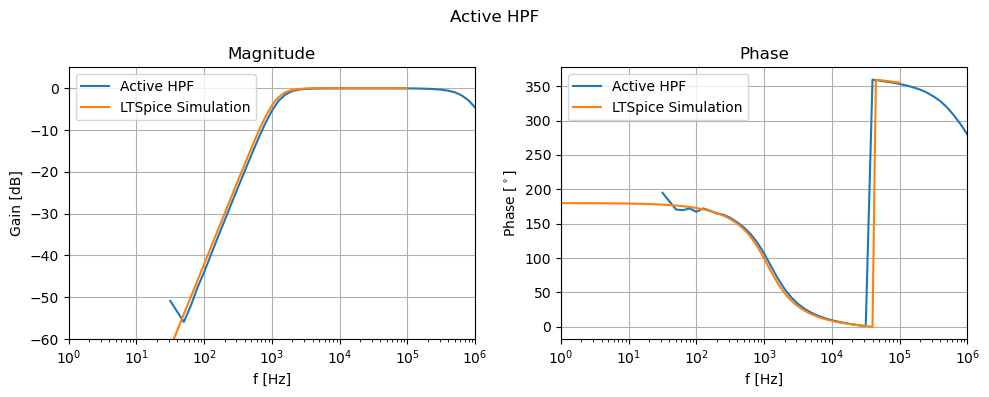

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("5_bode_activehpf.csv", fig, axes, name="Active HPF", cutoff_db=-60, argshift=lambda x: (x+360)%360.0)
plot_bode_spice("active_hpf.txt", axes, name="LTSpice Simulation", argshift=lambda x: (x+360)%360.0)
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
axstgs_filters[0].apply_axes(axes[0])
axstgs_filters[1].apply_axes(axes[1])
fig.suptitle("Active HPF")
fig.tight_layout()

/tmp/ipykernel_16219/2003998435.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e6))


Text(0.5, 0, 't [$\\mu$s]')

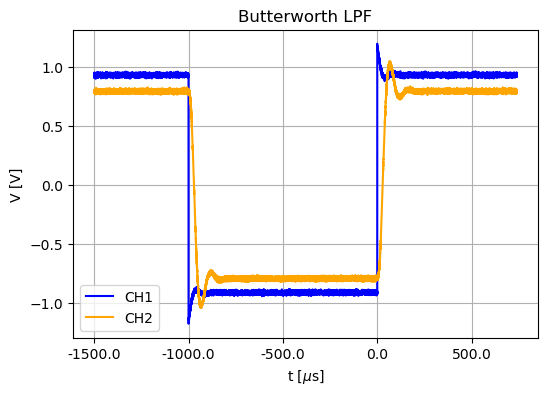

In [71]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("4_osc_bwlpf_zoom.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("Butterworth LPF")
axes.set_xticklabels(np.round(axes.get_xticks()*1e6))
axes.set_xlabel("t [$\mu$s]")

/tmp/ipykernel_16219/583297909.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e6))


Text(0.5, 0, 't [$\\mu$s]')

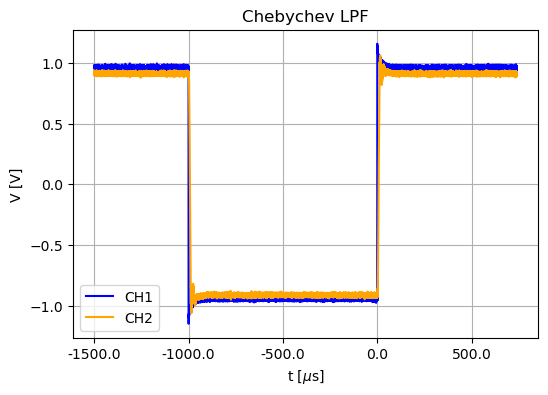

In [72]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("4_osc_cheblpf_re.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("Chebychev LPF")
axes.set_xticklabels(np.round(axes.get_xticks()*1e6))
axes.set_xlabel("t [$\mu$s]")

/tmp/ipykernel_16219/477103146.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e6))


Text(0.5, 0, 't [$\\mu$s]')

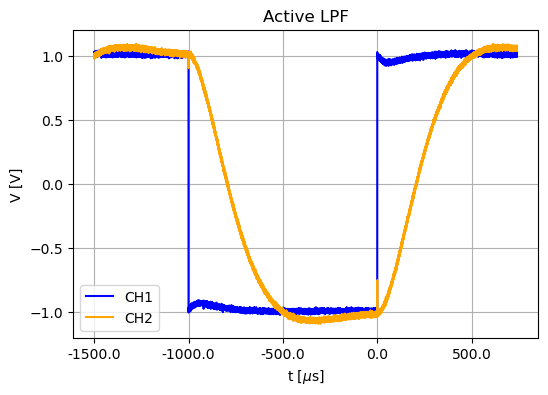

In [76]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("5_osc_activelpf.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("Active LPF")
axes.set_xticklabels(np.round(axes.get_xticks()*1e6))
axes.set_xlabel("t [$\mu$s]")

/tmp/ipykernel_16219/830563790.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e6))


Text(0.5, 0, 't [$\\mu$s]')

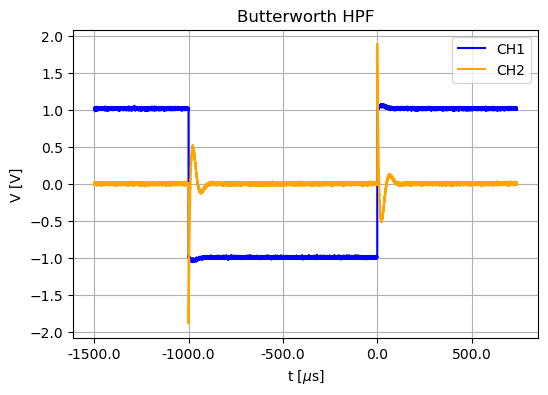

In [70]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("4_osc_bwhpf_zoom.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("Butterworth HPF")
axes.set_xticklabels(np.round(axes.get_xticks()*1e6))
axes.set_xlabel("t [$\mu$s]")

/tmp/ipykernel_16219/3524985905.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e6))


Text(0.5, 0, 't [$\\mu$s]')

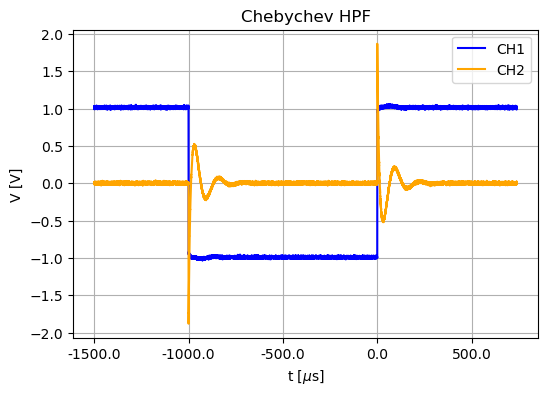

In [73]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("4_osc_chebhpf_zoom.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("Chebychev HPF")
axes.set_xticklabels(np.round(axes.get_xticks()*1e6))
axes.set_xlabel("t [$\mu$s]")

/tmp/ipykernel_16219/2782718945.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e6))


Text(0.5, 0, 't [$\\mu$s]')

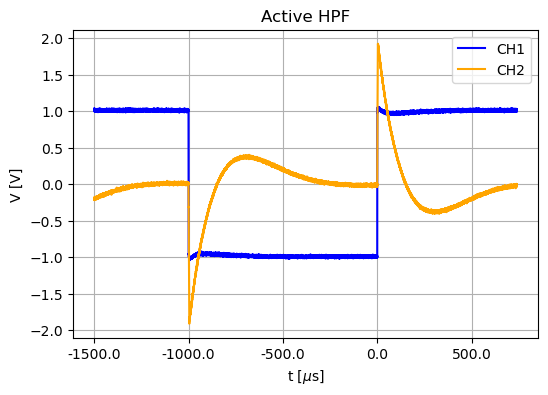

In [84]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("5_osc_activehpf.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("Active HPF")
axes.set_xticklabels(np.round(axes.get_xticks()*1e6))
axes.set_xlabel("t [$\mu$s]")